# Накопления

В банковском приложении нельзя видеть активы из других мест, например, золото, валюту и другие финансовые инструменты. Поэтому стоит создать платформу, где можно учитывать все виды активов и получать актуальную информацию по ценным бумагам, облигациям и курсам валют с MOEX и exchangerate.com.

In [1]:
deposits = Dict(
    "бессрочный" => 1_150_000,
    "до 01.09.2024 16%" => 250_000 + 250_000 * 0.16 * 6 / 12,
    "до 09.09.2024 16%" => 107_950 + 107_950 * 0.16 * 7 / 12,
    "долги 0%" => 300_000,
)

currency = Dict(
    # валюта
    "USD" => 3_700,
)

fonds = Dict(
    # фонды
    "SBMX" => 2_387,
    "SBSC" => 1_457,
    "SBPS" => 850,
    "SBGD" => 36,
)

flb = Dict(
    # ОФЗ
    "SU26218RMFS6" => 45,
    "SU26212RMFS9" => 25,
    "SU26207RMFS9" => 20,
    "SU26230RMFS1" => 20,
    "SU26232RMFS7" => 10,
    "SU26225RMFS1" => 10,
)

bonds = Dict(
    # корпоративные облигации
    "RU000A0ZYWY5" => 10,
)

stocks = Dict(
    # акции
    "SBER" => 210,
    "SBERP" => 210,
    "GAZP" => 280,
    "VKCO" => 46,
    "LKOH" => 2,
    "TCSG" => 5,
    "AFLT" => 250,
    "MBNK" => 7,
    "MTSS" => 60,
    "YDEX" => 3,
    "DIAS" => 2,
    "NVTK" => 9,
    "NLMK" => 60,
    "DELI" => 33,
    "TATN" => 13,
    "SPBE" => 58,
    "LSRG" => 10,
    "MOEX" => 30,
    "POSI" => 2,
    "LEAS" => 5,
    "RASP" => 10,
    "IVAT" => 10,
    "MTLR" => 20,
    "ROSN" => 3,
    "APTK" => 130,
    "KMAZ" => 10,
    # депозитарные расписки
    "OZON" => 3,
)

println("Все активы и пассивы созданы")

Все активы и пассивы созданы


### Получение данных с биржи MOEX

In [2]:
using HTTP

function fetch_security_data(url, key)
    response = HTTP.get(url)
    xml_data = String(response.body)
    return xml_data
end

sources = [
    ("SHARES/boards/TQBR", "акции"),
    ("SHARES/boards/TQTF", "ETF"),
    ("BONDS/boards/TQOB", "ОФЗ"),
    ("BONDS/boards/TQCB", "корпоративных облигации")
]

xml_data = Dict(key => fetch_security_data(
        "https://iss.moex.com/iss/engines/stock/markets/$(url)/securities.xml?iss.meta=off&iss.only=securities&securities.columns=SECID,PREVPRICE", 
        key
) for (url, key) in sources)

Dict{String, String} with 4 entries:
  "акции"                   => "<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n<do…
  "ETF"                     => "<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n<do…
  "корпоративных облигации" => "<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n<do…
  "ОФЗ"                     => "<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n<do…

In [3]:
using LightXML

function get_prevprice(xml_string::String, secid::String)
    doc = parse_string(xml_string)
    xroot = find_element(root(doc), "data")
    
    for row in child_elements(find_element(xroot, "rows"))
        if is_elementnode(row)
            row_secid = attribute(row, "SECID")
            if row_secid == secid
                return parse(Float64, attribute(row, "PREVPRICE"))
            end
        end
    end

    println(secid, " не найден")
    return 0
end

get_prevprice (generic function with 1 method)

### Получение курса USD/RUB с ExchangeRate

In [4]:
using JSON

function get_current_usd_to_rub()
    response = HTTP.get("https://api.exchangerate-api.com/v4/latest/USD")
    data = JSON.parse(String(response.body))
    return data["rates"]["RUB"]
end

function convert_usd_to_rub(amount_usd)
    exchange_rate = get_current_usd_to_rub()
    amount_rub = amount_usd * exchange_rate
    return amount_rub
end

convert_usd_to_rub (generic function with 1 method)

### Статистика

In [5]:
using Plots

# Предполагаем, что есть функции get_prevprice, convert_usd_to_rub и словари stocks, fonds, flb, bonds, deposits, currency
stocks_value = sum(get_prevprice(xml_data["акции"], key) * value for (key, value) in pairs(stocks))
fonds_value = sum(get_prevprice(xml_data["ETF"], key) * value for (key, value) in pairs(fonds))
flb_value = sum(get_prevprice(xml_data["ОФЗ"], key) * value * 1000 / 100 for (key, value) in pairs(flb))
bonds_value = sum(get_prevprice(xml_data["корпоративных облигации"], key) * value for (key, value) in pairs(bonds))
deposits_value = sum(value for (key, value) in pairs(deposits))
currency_value = convert_usd_to_rub(get(currency, "USD", 0.0))
summary = stocks_value + fonds_value + flb_value + bonds_value + deposits_value + currency_value

# Данные для графика
assets = ["Акции", "ETF", "ОФЗ", "Облигации", "Вклады", "Валюта"]
values = [stocks_value, fonds_value, flb_value, bonds_value, deposits_value, currency_value]

# Подсчет процентов для каждого типа актива
percents = [value / summary * 100 for value in values]

6-element Vector{Float64}:
 12.496781476203102
  2.092589661893226
  3.4793957617402866
  0.03583768118499569
 69.1336753840737
 12.76172003490469

In [6]:
println("Итоговая сумма: $(summary) рублей")

Итоговая сумма: 2.658654155333333e6 рублей


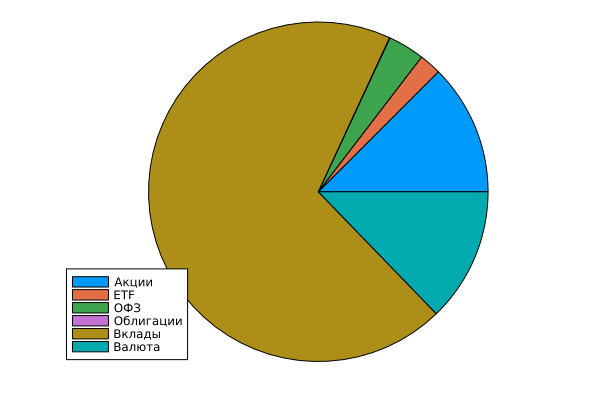

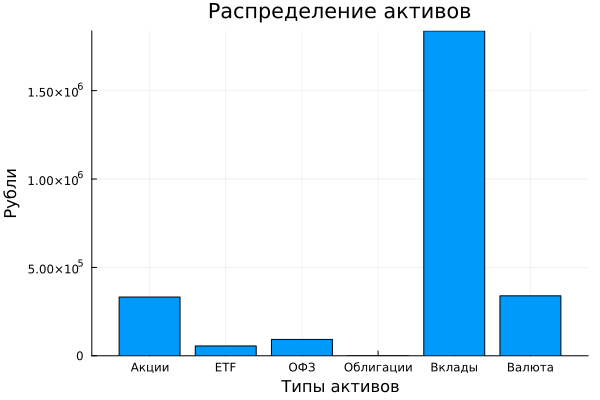

In [7]:
# Создание круговой диаграммы
pie_plot = pie(assets, percents, legend=true)

# И создание бар-графика
bar_plot = bar(assets, values, title="Распределение активов", xlabel="Типы активов", ylabel="Рубли", legend=false)

# Отображение круговой диаграммы
display(pie_plot)

# Отображение бар-графика
display(bar_plot)